In [3]:
import pandas as pd
import numpy as np
import gzip
import json
import re
import os
import sys
import collections
import category_encoders as ce
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from bokeh.io import output_notebook
from bokeh.plotting import figure, show, output_file
from bokeh.models import LabelSet, Label, HoverTool, ColumnDataSource


import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
df = pd.read_csv('small-100.csv')

In [16]:
df

,tag1,tag2,tag3,tag4,tag5,isbn
0,historical-fiction,mystery,historical-mystery,medieval,historical,184737297X
1,short-stories,fiction,french,français,literature,0440083087
2,horror,stephen-king,fiction,sci-fi,science-fiction,0142427896
3,non-fiction,society,politics,history,economics,1400041694
4,fiction,christian-fiction,christian,giveaways,shelfari-medical,1463650132
5,mystery,england,mysteries,mood-comforting,milieu-small-town,0854563903
6,classics,literature,classic,american-literature,rory-gilmore-challenge,0743564421
7,econimics-and-finance,business,poleco,behaviour-science,risk-management,1118727010
8,fantasy,young-adult,ya,paranormal,series,0698143760
9,mystery,crime,fiction,mysteries,cornwall,0752844458


In [3]:
u_tags = pd.unique(df.iloc[:, 0:5].values.ravel('K'))

In [4]:
len(u_tags)

201

In [5]:
# add new columns from unique tags
def add_columns(df, columns):
    newcols = {}
    for i in range(len(columns)):
        newcols['%s' % columns[i]] = np.nan*10
    return pd.concat([df, pd.DataFrame(newcols, index=df.index)], axis=1)

In [6]:
test = u_tags

dftags = add_columns(df, test)
dftags.drop(df.iloc[:, 0:5], axis = 1, inplace = True) 

In [7]:
df

,tag1,tag2,tag3,tag4,tag5,isbn
0,historical-fiction,mystery,historical-mystery,medieval,historical,184737297X
1,short-stories,fiction,french,français,literature,0440083087
2,horror,stephen-king,fiction,sci-fi,science-fiction,0142427896
3,non-fiction,society,politics,history,economics,1400041694
4,fiction,christian-fiction,christian,giveaways,shelfari-medical,1463650132
5,mystery,england,mysteries,mood-comforting,milieu-small-town,0854563903
6,classics,literature,classic,american-literature,rory-gilmore-challenge,0743564421
7,econimics-and-finance,business,poleco,behaviour-science,risk-management,1118727010
8,fantasy,young-adult,ya,paranormal,series,0698143760
9,mystery,crime,fiction,mysteries,cornwall,0752844458


In [8]:
#set([x for x in  if l.count(x) > 1])
alltags = [item for elm in df.iloc[:, 0:5].values for item in elm]
dup_tags = set([x for x in alltags if alltags.count(x) > 1])

In [9]:
def get_tag_counts_per_book(df, dup_tags):
    countdict ={}
    for book in df['isbn']:
        row = (df[df['isbn'] == book].iloc[:,:5].values)[0]
        counts = [int(val in dup_tags) for val in row]
        countdict[book] = {i: j for i,j in zip(row, counts)}
    return countdict

In [10]:
test_count = get_tag_counts_per_book(df, dup_tags)
print(test_count)
print(dup_tags)

{'184737297X': {'historical-fiction': 1, 'mystery': 1, 'historical-mystery': 0, 'medieval': 1, 'historical': 1}, '0440083087': {'short-stories': 1, 'fiction': 1, 'french': 1, 'français': 0, 'literature': 1}, '0142427896': {'horror': 1, 'stephen-king': 1, 'fiction': 1, 'sci-fi': 1, 'science-fiction': 1}, '1400041694': {'non-fiction': 1, 'society': 0, 'politics': 1, 'history': 1, 'economics': 0}, '1463650132': {'fiction': 1, 'christian-fiction': 1, 'christian': 1, 'giveaways': 0, 'shelfari-medical': 0}, '0854563903': {'mystery': 1, 'england': 0, 'mysteries': 1, 'mood-comforting': 0, 'milieu-small-town': 0}, '0743564421': {'classics': 1, 'literature': 1, 'classic': 1, 'american-literature': 0, 'rory-gilmore-challenge': 0}, '1118727010': {'econimics-and-finance': 0, 'business': 0, 'poleco': 0, 'behaviour-science': 0, 'risk-management': 0}, '0698143760': {'fantasy': 1, 'young-adult': 1, 'ya': 1, 'paranormal': 1, 'series': 1}, '0752844458': {'mystery': 1, 'crime': 1, 'fiction': 1, 'mysteries

In [96]:
#get_tag_counts_per_book(df, u_tags)
#alltags = [item for elm in df.iloc[:, 0:5].values for item in elm]
#collections.Counter(alltags)

In [82]:
dftags.head()

,isbn,historical-fiction,short-stories,horror,non-fiction,fiction,mystery,classics,econimics-and-finance,fantasy,...,humour,self-improvement,dnf,game-of-thrones,latin-america,séries,john-connolly,fairy-tale,anthology,morgan-llywelyn
0,184737297X,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0440083087,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0142427896,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1400041694,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1463650132,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
test_count['0752844458']

{'mystery': 1, 'crime': 1, 'fiction': 1, 'mysteries': 1, 'cornwall': 0}

In [81]:
pd.DataFrame.from_dict(test_count, orient='index').head()

,historical-fiction,mystery,historical-mystery,medieval,historical,short-stories,fiction,french,français,literature,...,fantasia,la-rueda-del-tiempo,séries,john-connolly,poldark,fairy-tale,anthologies,anthology,science-fiction-fantasy,morgan-llywelyn
0060773758,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0062294482,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0062300741,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0062373374,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0142427896,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
# testing with 100 books
df = pd.read_csv('small-100.csv')

alltags = [item for elm in df.iloc[:, 0:5].values for item in elm]
dup_tags = set([x for x in alltags if alltags.count(x) > 1])

test_count = get_tag_counts_per_book(df, dup_tags)



In [15]:
df_count = pd.DataFrame.from_dict(test_count, orient='index')

In [16]:
df_count.head()

,historical-fiction,mystery,historical-mystery,medieval,historical,short-stories,fiction,french,français,literature,...,fantasia,la-rueda-del-tiempo,séries,john-connolly,poldark,fairy-tale,anthologies,anthology,science-fiction-fantasy,morgan-llywelyn
0060773758,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0062294482,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0062300741,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0062373374,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0142427896,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
df_count.fillna(0, inplace=True)

In [18]:
df_count.head()

,historical-fiction,mystery,historical-mystery,medieval,historical,short-stories,fiction,french,français,literature,...,fantasia,la-rueda-del-tiempo,séries,john-connolly,poldark,fairy-tale,anthologies,anthology,science-fiction-fantasy,morgan-llywelyn
0060773758,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0062294482,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0062300741,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0062373374,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0142427896,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
print(df_count.describe())

       historical-fiction     mystery  historical-mystery    medieval  \
count          100.000000  100.000000               100.0  100.000000   
mean             0.040000    0.240000                 0.0    0.030000   
std              0.196946    0.429235                 0.0    0.171447   
min              0.000000    0.000000                 0.0    0.000000   
25%              0.000000    0.000000                 0.0    0.000000   
50%              0.000000    0.000000                 0.0    0.000000   
75%              0.000000    0.000000                 0.0    0.000000   
max              1.000000    1.000000                 0.0    1.000000   

       historical  short-stories  fiction      french  français  literature  \
count  100.000000     100.000000   100.00  100.000000     100.0  100.000000   
mean     0.060000       0.070000     0.45    0.020000       0.0    0.070000   
std      0.238683       0.256432     0.50    0.140705       0.0    0.256432   
min      0.000000       0.

In [21]:
#print(df_count.isna().sum())

In [123]:
df_count.info

<bound method DataFrame.info of             historical-fiction  mystery  historical-mystery  medieval  \
0060773758                 0.0      0.0                 0.0       0.0   
0062294482                 0.0      0.0                 0.0       0.0   
0062300741                 0.0      1.0                 0.0       0.0   
0062373374                 0.0      0.0                 0.0       0.0   
0142427896                 0.0      0.0                 0.0       0.0   
0156182890                 0.0      0.0                 0.0       0.0   
0307706524                 0.0      0.0                 0.0       0.0   
0307947599                 0.0      1.0                 0.0       0.0   
0307984788                 0.0      0.0                 0.0       0.0   
031621647X                 0.0      0.0                 0.0       0.0   
0316219169                 0.0      0.0                 0.0       0.0   
0340897244                 0.0      1.0                 0.0       0.0   
0340897260         

In [22]:
#X = df_count.iloc[:,0:201].reset_index(drop=True)
X = np.array(df_count.iloc[:,0:201].reset_index(drop=True)).astype(float)

In [23]:
y = np.array(df_count.index)

In [24]:
kmeans = KMeans(n_clusters=10, n_jobs=1)
kmeans.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=10, n_init=10, n_jobs=1, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [154]:
correct = 0
for i in range(len(X)):
    predict_me = np.array(X[i].astype(float))
    predict_me = predict_me.reshape(-1, len(predict_me))
    prediction = kmeans.predict(predict_me)
    if prediction[0] == y[i]:
        correct += 1

print(correct/len(X))

0.0


In [25]:
centroids = kmeans.cluster_centers_

In [28]:
len(centroids[1])

201

In [31]:
#plt.scatter(X, y)
#for centroid in enumerate(centroids):
#    plt.scatter(*centroid)

In [32]:
#features = ['tag1', 'tag2', 'tag3', 'tag4']
# Separating out the features
#x = tmp.loc[:, features].values

# Separating out the target
#y = tmp.loc[:,['isbn']].values

# Standardizing the features
x = StandardScaler().fit_transform(X)

In [33]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

In [36]:
df_count['isbn'] = df.index

In [38]:
df_count.reset_index(level=0, inplace=True)

In [39]:
df_count.head()

,index,historical-fiction,mystery,historical-mystery,medieval,historical,short-stories,fiction,french,français,...,la-rueda-del-tiempo,séries,john-connolly,poldark,fairy-tale,anthologies,anthology,science-fiction-fantasy,morgan-llywelyn,isbn
0,0060773758,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0062294482,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,0062300741,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
3,0062373374,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
4,0142427896,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4


In [40]:
finalDf = pd.concat([principalDf, df_count[['index']]], axis = 1)

In [60]:
output_notebook()

#fig = plt.figure(figsize = (8,8))
#ax = fig.add_subplot(1,1,1) 

p = figure(title='2 component PCA')
p.xaxis[0].axis_label = 'Principal Component 1'
p.yaxis[0].axis_label = 'Principal Component 2'

targets = df_count['index'].tolist()

#colors = ['r', 'g', 'b']
for target in targets:
    indicesToKeep = finalDf['index'] == target
    p.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2'])
               #, c = color
#               , s = 50)
#p.legend(targets)
#ax.grid()
show(p)



Loading BokehJS ...

In [79]:
#print(finalDf.head())
finalDf[finalDf['principal component 1'] > 5]


,principal component 1,principal component 2,index
8,5.692347,-2.627430,0307984788
23,6.757081,-2.951675,0395083621
37,5.692347,-2.627430,0679767789
51,5.741009,-2.703634,0805091262
70,5.520046,-2.661253,1441872426


In [78]:
df[df['isbn'] == '0307984788']

,tag1,tag2,tag3,tag4,tag5,isbn
15,non-fiction,memoir,nonfiction,biography,books-about-books,0307984788


In [80]:
df[df['isbn'] == '0679767789']

,tag1,tag2,tag3,tag4,tag5,isbn
49,memoir,non-fiction,nonfiction,memoirs,biography,0679767789


In [88]:
# Create source for plotting, useful for Labeling afterwards
#source = ColumnDataSource(data=dict(pc1=finalDf['principal component 1'].to_list(), 
#                                    pc2=finalDf['principal component 2'].to_list(),
#                                    names=finalDf['index'].to_list()))


# Formatting title and labels
#p = figure(title='2 component PCA')
#p.xaxis[0].axis_label = 'principal component 1'
#p.yaxis[0].axis_label = 'principal component 2'

#p.scatter(source=source, alpha=0.6, line_color=None)
#labels = LabelSet(text='names', source=source)
#p.add_layout(labels)

#show(p)

In [106]:
alltags_count = collections.Counter(alltags)
dcount = dict(alltags_count)

In [103]:
sorted_tags_count = list(alltags_count.values()).sort()

In [125]:
s  = pd.Series(dcount,index=dcount.keys()).sort_values(ascending=False)

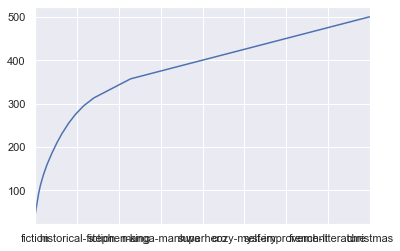

In [129]:
s.cumsum().plot()

In [4]:
df = pd.read_csv('sorted_tags-all.csv')


Text(0.5, 0, 'Tag')

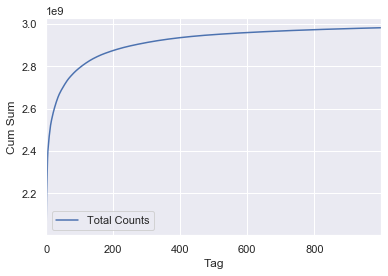

In [12]:
sns.set()
df.iloc[:1000, :].cumsum().plot()
plt.ylabel('Cum Sum')
plt.xlabel('Tag')



In [13]:
df.head()

,tag,Total Counts
0,to-read,2049566994
1,currently-reading,131995760
2,classics,62273395
3,favorites,61776179
4,fiction,59841666


In [41]:
df[(df['tag'] == 'classic') | (df['tag'] == 'classics')].sum()

tag             classicsclassic
Total Counts           74858425
dtype: object

In [19]:
df[(df['tag'] == 'fantasy')].sum()

tag              fantasy
Total Counts    35708932
dtype: object

In [20]:
df[(df['tag'] == 'romance')].sum()

tag              romance
Total Counts    14397702
dtype: object

In [21]:
df[(df['tag'] == 'science-fiction') | (df['tag'] == 'sci-fi') | (df['tag'] == 'scifi')].sum()

tag             science-fictionsci-fiscifi
Total Counts                      18219705
dtype: object

In [22]:
df[(df['tag'] == 'mystery')].sum()

tag              mystery
Total Counts    12300767
dtype: object

In [23]:
df[(df['tag'] == 'business')].sum()

tag             business
Total Counts      958698
dtype: object

In [24]:
df[(df['tag'] == 'economics')].sum()

tag             economics
Total Counts       373774
dtype: object

In [40]:
types = {'classics': 0.024, 'fantasy': 0.0117, 'romance': 0.00472, 'science-fiction': 0.006, 
         'mystery': 0.004, 'economics': 0.000122, 'business': 0.00031}

In [26]:
df['Total Counts'].sum()

3051887585

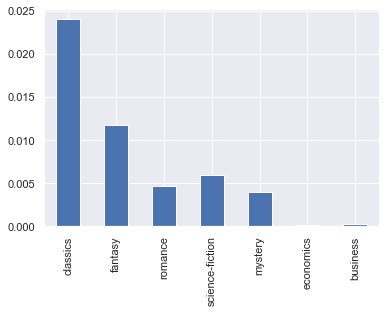

In [42]:
s  = pd.Series(types,index=types.keys())
s.plot.bar()
sns.set()